<a href="https://colab.research.google.com/github/Tonge-Shim/1/blob/master/finalproject_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform = transforms.Compose(
    [transforms.Resize((96, 96)),transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,#50000개
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,#10000개
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#Inception module

시작 전에, save_weights의 폴더를 만들어 놓고 시작.

In [ ]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

In [ ]:
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3_r, f_3x3, f_5x5_r, f_5x5, f_pp):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvBlock(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, f_3x3_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_3x3_r, f_3x3, kernel_size=3, stride=1, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, f_5x5_r, kernel_size=1, stride=1, padding=0),
            ConvBlock(f_5x5_r, f_5x5, kernel_size=5, stride=1, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, f_pp, kernel_size=1, stride=1, padding=0)
        )
        
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        
        return torch.cat([branch1, branch2, branch3, branch4], 1)

In [ ]:
class InceptionAux(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        self.act = nn.ReLU()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.act(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
class semiGoogLeNet(nn.Module):
    
    def __init__(self, num_classes = 10):
        super(semiGoogLeNet, self).__init__()
      
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.conv2 = ConvBlock(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception1 = InceptionModule(in_channels=192,
                                           f_1x1=64,
                                           f_3x3_r=96,
                                           f_3x3=128,
                                           f_5x5_r=16,
                                           f_5x5=32,
                                           f_pp=32)
    
        self.pool3 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)
        self.inception2 = InceptionModule(in_channels=256,
                                           f_1x1=192,
                                           f_3x3_r=96,
                                           f_3x3=208,
                                           f_5x5_r=16,
                                           f_5x5=48,
                                           f_pp=64)
        self.aux2 = InceptionAux(512, num_classes) 
        self.inception3 = InceptionModule(in_channels=512,
                                           f_1x1=160,
                                           f_3x3_r=112,
                                           f_3x3=224,
                                           f_5x5_r=24,
                                           f_5x5=64,
                                           f_pp=64)

        self.inception4 = InceptionModule(in_channels=512,
                                           f_1x1=112,
                                           f_3x3_r=144,
                                           f_3x3=288,
                                           f_5x5_r=32,
                                           f_5x5=64,
                                           f_pp=64)
        self.aux4 = InceptionAux(528, num_classes)
        self.inception5 = InceptionModule(in_channels=528 ,
                                           f_1x1=256,
                                           f_3x3_r=160,
                                           f_3x3=320,
                                           f_5x5_r=32,
                                           f_5x5=128,
                                           f_pp=128)
        self.pool4 = nn.MaxPool2d(3, stride=2, padding=0, ceil_mode=True)

        self.inception6 = InceptionModule(in_channels=832,
                                           f_1x1=384,
                                           f_3x3_r=192,
                                           f_3x3=384,
                                           f_5x5_r=48,
                                           f_5x5=128,
                                           f_pp=128)
        
        self.pool5 = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(1024, num_classes)
        
        
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.inception1(x)
        x = self.pool3(x)
        x = self.inception2(x)
  
        aux1 = self.aux2(x)
        
        x = self.inception3(x)
        x = self.inception4(x)
  
        aux2 = self.aux4(x)
        
        x = self.inception5(x)
        x = self.pool4(x)
        x = self.inception6(x)
        x = self.pool5(x)#avg
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x, aux1, aux2

In [ ]:
model = semiGoogLeNet()

In [ ]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Define a Loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
def train_model():
    EPOCHS = 17
    nb_examples = 50000
    train_costs = []
    #Training phase.
    
    for epoch in range(EPOCHS):

        train_loss = 0
        correct_train = 0
        
        model.train().cuda()
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction0, prediction1, prediction2 = model(inputs)
            
            # Compute the loss.
            loss0 = criterion(prediction0, labels)
            loss1 = criterion(prediction1, labels)
            loss2 = criterion(prediction2, labels)
            
            loss = loss0 + 0.3 * loss1 + 0.4 * loss2
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction0.data, 1)
            correct_train += (predicted == labels).float().sum().item()
            
            # Compute batch loss.
            train_loss += (loss.data.item() * inputs.shape[0])


        train_loss /= nb_examples
        train_costs.append(train_loss)
        train_acc =  correct_train / nb_examples

        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} "
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc))
        torch.save(model.state_dict(), 'save_weights/checkpoint_gpu_{}'.format(epoch + 1)) 
                                                                
    torch.save(model.state_dict(), '/content/save_weights/googlenet_weights_gpu')  
        
    return train_costs

In [ ]:
train_costs= train_model()

[Epoch 1/17]: train-loss = 2.131475 | train-acc = 0.557 
[Epoch 2/17]: train-loss = 1.331212 | train-acc = 0.734 
[Epoch 3/17]: train-loss = 1.000035 | train-acc = 0.805 
[Epoch 4/17]: train-loss = 0.805605 | train-acc = 0.846 
[Epoch 5/17]: train-loss = 0.645721 | train-acc = 0.878 
[Epoch 6/17]: train-loss = 0.520736 | train-acc = 0.904 
[Epoch 7/17]: train-loss = 0.417545 | train-acc = 0.924 
[Epoch 8/17]: train-loss = 0.355721 | train-acc = 0.936 
[Epoch 9/17]: train-loss = 0.278343 | train-acc = 0.951 
[Epoch 10/17]: train-loss = 0.227839 | train-acc = 0.961 
[Epoch 11/17]: train-loss = 0.186951 | train-acc = 0.970 
[Epoch 12/17]: train-loss = 0.157757 | train-acc = 0.974 
[Epoch 13/17]: train-loss = 0.139440 | train-acc = 0.977 
[Epoch 14/17]: train-loss = 0.133930 | train-acc = 0.979 
[Epoch 15/17]: train-loss = 0.112604 | train-acc = 0.982 
[Epoch 16/17]: train-loss = 0.102190 | train-acc = 0.984 
[Epoch 17/17]: train-loss = 0.059000 | train-acc = 0.992 


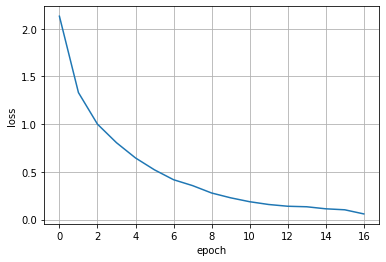

In [ ]:
plt.plot(range(17), train_costs)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

In [ ]:
model = semiGoogLeNet()
model.load_state_dict(torch.load('/content/save_weights/googlenet_weights_gpu'))

<All keys matched successfully>

In [ ]:
nb_test_examples = 10000
correct = 0 

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction, _, _ = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / nb_test_examples*100
print('Test accuracy: {}%'.format(test_accuracy))

Test accuracy: 83.46000000000001%
